First we need to import utils package and tensorflow with addons.

In [1]:
import os
from datetime import datetime  

from utils import *
import tensorflow as tf
import tensorflow_addons as tfa
tf.config.experimental.set_memory_growth
import gc
gc.collect()

set_seed(42)

2023-04-27 18:04:26.345217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 18:04:26.952566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# ds_name = 'ml-20m'
# # netflix: len(self.pr) = 13668
# # divisors: {1,2,3,4,6,12,17,34,51,67,68,102,134,201,204,268,402,804,1139,2278,3417,4556,6834,13668}
# chunk = 68

ds_name = 'netflix'
# netflix: len(self.pr) = 46344
# divisors: {1,2,3,4,6,8,12,24,1931,3862,5793,7724,11586,15448,23172,46344}
chunk = 24

# ds_name = 'steam-200k'

data_path = os.path.join('/home/ubuntu/vasp/Datasets/', ds_name, 'preprocessed_vasp/')

str_date_time = datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y_%H-%M-%S")
model_name = str('VASP_'+ds_name+'_'+str_date_time)

data_path, model_name

('/home/ubuntu/vasp/Datasets/netflix/preprocessed_vasp/',
 'VASP_netflix_27-04-2023_18-04-28')

Next, we define our model. Note that reparametrization trick is done manually - it can be done with tensorflow probability package, which is doing that by itself automatically.

In [4]:
class DiagonalToZero(tf.keras.constraints.Constraint):
    def __call__(self, w):
        """Set diagonal to zero"""
        q = tf.linalg.set_diag(w, tf.zeros(w.shape[0:-1]), name=None)
        return q

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a basket."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VASP(Model):
    class Model(tf.keras.Model):
        def __init__(self, num_words, latent=1024, hidden=1024, items_sampling=1.):
            """
            num_words             nr of items in dataset (size of tokenizer)
            latent                size of latent space
            hidden                size of hidden layers
            items_sampling        Large items datatsets can be very gpu memory consuming in EASE layer.
                                  This coefficient reduces number of ease parametrs by taking only
                                  fraction of items sorted by popularity as input for model.
                                  Note: This coef should be somewhere around coverage@100 achieved by full
                                  size model.
                                  For ML20M this coef should be between 0.4888 (coverage@100 for full model)
                                  and 1.0
                                  For Netflix this coef should be between 0.7055 (coverage@100 for full
                                  model) and 1.0
            """
            super(VASP.Model, self).__init__()

            self.sampled_items = int(num_words * items_sampling)

            assert self.sampled_items > 0
            assert self.sampled_items <= num_words

            self.s = self.sampled_items < num_words

            # ************* ENCODER ***********************
            self.encoder1 = tf.keras.layers.Dense(hidden)
            self.ln1 = tf.keras.layers.LayerNormalization()
            self.encoder2 = tf.keras.layers.Dense(hidden)
            self.ln2 = tf.keras.layers.LayerNormalization()
            self.encoder3 = tf.keras.layers.Dense(hidden)
            self.ln3 = tf.keras.layers.LayerNormalization()
            self.encoder4 = tf.keras.layers.Dense(hidden)
            self.ln4 = tf.keras.layers.LayerNormalization()
            self.encoder5 = tf.keras.layers.Dense(hidden)
            self.ln5 = tf.keras.layers.LayerNormalization()
            self.encoder6 = tf.keras.layers.Dense(hidden)
            self.ln6 = tf.keras.layers.LayerNormalization()
            self.encoder7 = tf.keras.layers.Dense(hidden)
            self.ln7 = tf.keras.layers.LayerNormalization()

            # ************* SAMPLING **********************
            self.dense_mean = tf.keras.layers.Dense(latent,
                                                    name="Mean")
            self.dense_log_var = tf.keras.layers.Dense(latent,
                                                       name="log_var")

            self.sampling = Sampling(name='Sampler')

            # ************* DECODER ***********************
            self.decoder1 = tf.keras.layers.Dense(hidden)
            self.dln1 = tf.keras.layers.LayerNormalization()
            self.decoder2 = tf.keras.layers.Dense(hidden)
            self.dln2 = tf.keras.layers.LayerNormalization()
            self.decoder3 = tf.keras.layers.Dense(hidden)
            self.dln3 = tf.keras.layers.LayerNormalization()
            self.decoder4 = tf.keras.layers.Dense(hidden)
            self.dln4 = tf.keras.layers.LayerNormalization()
            self.decoder5 = tf.keras.layers.Dense(hidden)
            self.dln5 = tf.keras.layers.LayerNormalization()

            self.decoder_resnet = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderR")
            self.decoder_latent = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderL")

            # ************* PARALLEL SHALLOW PATH *********

            self.ease = tf.keras.layers.Dense(
                self.sampled_items,
                activation='sigmoid',
                use_bias=False,
                kernel_constraint=DiagonalToZero(),  # critical to prevent learning simple identity
            )

        def call(self, x, training=None):
            sampling = self.s
            if sampling:
                sampled_x = x[:, :self.sampled_items]
                non_sampled = x[:, self.sampled_items:] * 0.
            else:
                sampled_x = x

            z_mean, z_log_var, z = self.encode(sampled_x)
            if training:
                d = self.decode(z)
                # Add KL divergence regularization loss.
                kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
                kl_loss = tf.reduce_mean(kl_loss)
                kl_loss *= -0.5
                self.add_loss(kl_loss)
                self.add_metric(kl_loss, name="kl_div")
            else:
                d = self.decode(z_mean)

            if sampling:
                d = tf.concat([d, non_sampled], axis=-1)

            ease = self.ease(sampled_x)

            if sampling:
                ease = tf.concat([ease, non_sampled], axis=-1)

            return d * ease

        def decode(self, x):
            e0 = x
            e1 = self.dln1(tf.keras.activations.swish(self.decoder1(e0)))
            e2 = self.dln2(tf.keras.activations.swish(self.decoder2(e1) + e1))
            e3 = self.dln3(tf.keras.activations.swish(self.decoder3(e2) + e1 + e2))
            e4 = self.dln4(tf.keras.activations.swish(self.decoder4(e3) + e1 + e2 + e3))
            e5 = self.dln5(tf.keras.activations.swish(self.decoder5(e4) + e1 + e2 + e3 + e4))

            dr = self.decoder_resnet(e5)
            dl = self.decoder_latent(x)

            return dr * dl

        def encode(self, x):
            e0 = x
            e1 = self.ln1(tf.keras.activations.swish(self.encoder1(e0)))
            e2 = self.ln2(tf.keras.activations.swish(self.encoder2(e1) + e1))
            e3 = self.ln3(tf.keras.activations.swish(self.encoder3(e2) + e1 + e2))
            e4 = self.ln4(tf.keras.activations.swish(self.encoder4(e3) + e1 + e2 + e3))
            e5 = self.ln5(tf.keras.activations.swish(self.encoder5(e4) + e1 + e2 + e3 + e4))
            e6 = self.ln6(tf.keras.activations.swish(self.encoder6(e5) + e1 + e2 + e3 + e4 + e5))
            e7 = self.ln7(tf.keras.activations.swish(self.encoder7(e6) + e1 + e2 + e3 + e4 + e5 + e6))

            z_mean = self.dense_mean(e7)
            z_log_var = self.dense_log_var(e7)
            z = self.sampling((z_mean, z_log_var))

            return z_mean, z_log_var, z

    def create_model(self, latent=2048, hidden=4096, ease_items_sampling=1., summary=False):
        self.model = VASP.Model(self.dataset.num_words, latent, hidden, ease_items_sampling)
        self.model(self.split.train_gen[0][0])
        if summary:
            self.model.summary()
        self.mc = MetricsCallback(self)

    def compile_model(self, lr=0.00002, fl_alpha=0.25, fl_gamma=2.0):
        """
        lr         learning rate of Nadam optimizer
        fl_alpha   alpha parameter of focal crossentropy
        fl_gamma   gamma parameter of focal crossentropy
        """
        self.model.compile(
            optimizer=tf.keras.optimizers.Nadam(lr),
            loss=lambda x, y: tfa.losses.sigmoid_focal_crossentropy(x, y, alpha=fl_alpha, gamma=fl_gamma),
            metrics=['mse', cosine_loss]
        )

    def train_model(self, epochs=150):
        self.model.fit(
            self.split.train_gen,
            validation_data=self.split.validation_gen,
            epochs=epochs,
            callbacks=[self.mc]
        )



Now, we can load previously preprocessed dataset. We also load pre-defined train/test/validation split.

In [5]:
dataset = Data(d=data_path, pruning='u5')
dataset.splits = []

dataset.create_splits(1, 10000, shuffle=False, n_fold=False, generators=False, batch_size=1024, chunk=chunk)
dataset.split.train_users = pd.read_json(os.path.join(data_path, "train_users.json")).userid.apply(str).to_frame()
dataset.split.validation_users = pd.read_json(os.path.join(data_path, "val_users.json")).userid.apply(str).to_frame()
dataset.split.test_users = pd.read_json(os.path.join(data_path, "test_users.json")).userid.apply(str).to_frame()
dataset.split.generators()

dataset.split

Reading users_pu5
Reading items_pu5
Reading purchases_txt_pu5
Reading items_sorted_pu5
Reading users_sorted_pu5
Read all in 3.225402593612671
Tokenizer trained for 17769 items.
Creating 1 splits of 10000 samples each.
Creating split nr. 1
SplitGenerator init done in 22.66240906715393 secs.
SplitGenerator init done in 2.8135831356048584 secs.
SplitGenerator init done in 2.803433418273926 secs.
Creating evaluator
Creating test split evaluator with leave_random_20_pct_out method.
Creating validation split evaluator with leave_random_20_pct_out method.


Now we can create an instance of our model and train it.

For validation during training we sample 80% of the user's interactions randomly as input for the model, and then we measure Recall@20, Recall@50 and NDCG@100 for predicted interactions against the remaining 20% of the user's interactions.

This method can give different results for different seeds, but since it is used for validation during training only, it's good enough.

Train for 50 epochs with lr 0.00005
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 19ms/step
iv: 46344
pr: 46344
ivx: 46344
range: range(0, 1931)
self.chunk: 24
Model metrics:Recall@5=0.2677 Recall@20=0.2879 Recall@50=0.3733 NCDG@100=0.3227 Coverage@5=0.0911 Coverage@20=0.1412 Coverage@50=0.188 Coverage@100=0.2288 
New best for NCDG@100
New best for Recall@20
New best for Recall@50
361/361 [==============================] - 395s 1s/step - loss: 31.2290 - mse: 0.0045 - cosine_loss: 0.8133 - kl_div: 0.6636 - val_loss: 47.0112 - val_mse: 0.0064 - val_cosine_loss: 0.7045 - val_kl_div: 0.0000e+00


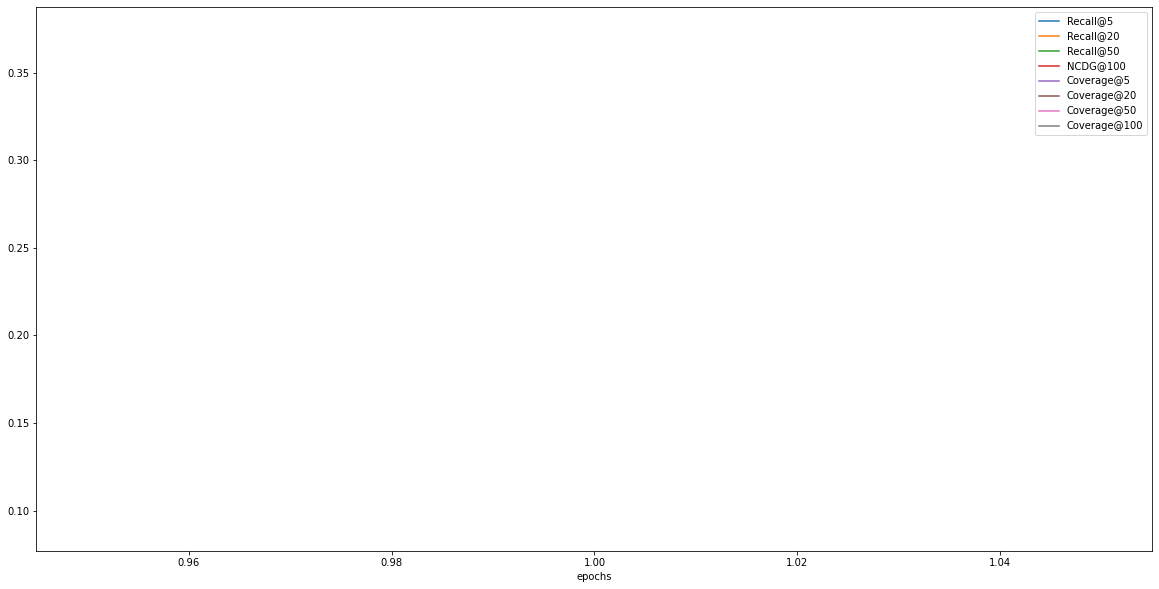

In [6]:
m = VASP(dataset.split, name=model_name)
m.create_model(latent=2048, hidden=4096, ease_items_sampling=0.33)
#m.model.summary()
print("=" * 80)
print("Train for 50 epochs with lr 0.00005")
m.compile_model(lr=0.00005, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(1)
#print("=" * 80)
#print("Than train for 20 epochs with lr 0.00001")
#m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
#m.train_model(20)
#print("=" * 80)
#print("Than train for 20 epochs with lr 0.000001")
#m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
#m.train_model(20)

Dataframe with the details of the training.

In [7]:
m.mc.get_history_df()

,epochs,Recall@5,Recall@20,Recall@50,NCDG@100,Coverage@5,Coverage@20,Coverage@50,Coverage@100
0,1,0.26766,0.287931,0.37325,0.322677,0.091119,0.141209,0.187978,0.228782


And the details of the training as a plot.

<AxesSubplot:xlabel='epochs'>

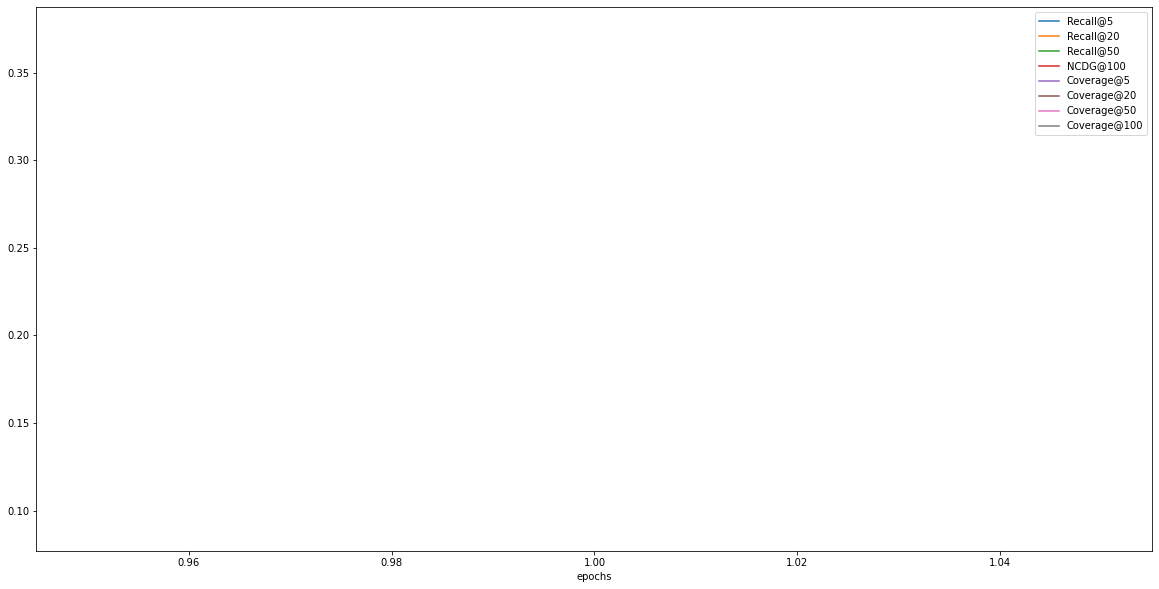

In [8]:
m.mc.plot_history()

For final evaluation we do 5-fold validation on the user's interaction history. We think that this is more objective measure than only hide sampled 20% of the user's interactions randomly.

In [9]:
# 5-fold evaluation on the test set

test_r20s = []
test_r50s = []
test_n100s = []

for fold in range(1,6):
    ev=Evaluator(m.split, method=str(fold)+'_20')
    ev.update(m.model)

    test_n100s.append(ev.get_ncdg(100))
    test_r20s.append(ev.get_recall(20))
    test_r50s.append(ev.get_recall(50))

print("TEST SET (MEAN)")
print("5-fold mean NCDG@100", round(sum(test_n100s) / len(test_n100s),3))
print("5-fold mean Recall@20", round(sum(test_r20s) / len(test_r20s),3))
print("5-fold mean Recall@50", round(sum(test_r50s) / len(test_r50s),3))

Creating test split evaluator with 1_20 method.
